## Central Computation



In [1]:
# Import libraries
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

### Function converts from HTML to list of lists

In [2]:
def convertFile(filename):
    name_list=[]
    position_list=[]
    nationality_list=[]
    appearances_list=[]
    sheet_list=[]
    goal_list=[]
    assist_list=[]
    with open('./team_player.html/'+filename, "r") as file:
        content = file.readlines()
        content = "".join(content)
        bs_content = bs(content, "lxml")

    # Get all the name of players 
    name_result = bs_content.find_all("h4", {"class": "name"})
    for name in name_result:
        name_list.append(name.get_text())


    # Get the position of players
    position_result = bs_content.find_all("span", {"class": "position"})
    for pos in position_result:
        position_list.append(pos.get_text())

    # Get the nationality of players
    nationality_result = bs_content.find_all("span", {"class": "playerCountry"})
    for country in nationality_result:
        nationality_list.append(country.get_text())


    # Get the appearances of players
    # Appearances: The number of matches that the players participate in a season
    appearances_result = bs_content.find_all(text="Appearances")
    for a in appearances_result:
        b = a.parent
        address_dd = b.parent
        target_dd = address_dd.findNext('dd')
        appearances_list.append(target_dd.get_text())



    # Get the clean sheets of players
    # Clean sheets: Number of games that the player participate in the match and the opposing team has no score.
    sheet_result = bs_content.find_all(text="Clean sheets")
    for a in sheet_result:
        b = a.parent
        address_dd = b.parent
        target_dd = address_dd.findNext('dd')
        sheet_list.append(target_dd.get_text())


    # Get the number of goals for each player
    goal_result = bs_content.find_all(text="Goals")
    for a in goal_result:
        b = a.parent
        address_dd = b.parent
        target_dd = address_dd.findNext('dd')
        goal_list.append(target_dd.get_text())


    # Get the number of assists for each player
    assist_result = bs_content.find_all(text="Assists")
    for a in assist_result:
        b = a.parent
        address_dd = b.parent
        target_dd = address_dd.findNext('dd')
        assist_list.append(target_dd.get_text())

    player_list=[]
    sheet_count=0
    goal_count=0
    assist_count=0
    # Append the information of the players into a list of lists
    for count, value in enumerate(name_list):
        get_list=[]
        get_list.append(value)
        get_list.append(position_list[count])
        get_list.append(nationality_list[count])
        get_list.append(appearances_list[count])
        if position_list[count] == "Goalkeeper" or position_list[count] == "Defender":
            get_list.append(sheet_list[sheet_count])
            sheet_count+=1
        else:
            get_list.append(np.NaN)
        
        if position_list[count] == "Defender" or position_list[count] == "Midfielder" or position_list[count] =="Forward":
            get_list.append(goal_list[goal_count])
            goal_count+=1
        else:
            get_list.append(np.NaN)
            
        if position_list[count] == "Midfielder" or position_list[count] == "Forward":
            get_list.append(assist_list[assist_count])
            assist_count+=1
        else:
            get_list.append(np.NaN)
            
        player_list.append(get_list)
        
    return player_list
    


In [3]:
# Convert from list of lists to DataFrame for each team
# Then, store the DataFrame of each team in the dictionary
team_dict = {}
for filename in os.listdir("./team_player.html"):
    df = pd.DataFrame(convertFile(filename), columns=["Name", "Position", "Nationality", "Appearances", "Clean Sheets", "Goals", "Assists"])
    team_dict[filename[:-5]] = df

### Determine the position to be used by calculating which role has the most migrant players

In [4]:
# Midfielder has the most international players, so the appearances, goals, and assists will be use to analyze
count_position={}
for filename in team_dict:
    get_df=team_dict[filename]
    for count, data in get_df.iterrows():
        if data['Nationality'] !="England":
            if data['Position'] not in count_position:
                count_position[data['Position']]=1
            else:
                count_position[data['Position']] +=1
print(count_position)

{'Goalkeeper': 46, 'Defender': 129, 'Midfielder': 135, 'Forward': 77}


### Train the logistic regression model to predict if the player is from England or not based on appearances, goals, and assists

In [5]:
# Convert from one-dimensional array to two-dimensional array
def np_arr(X_train, X_test, y_train, y_test):
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)


    X_train = X_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    return X_train, X_test, y_train, y_test


In [6]:
# Positions that have appearances: Goalkeeper, Defender, Midfielder, Forward
# Positions that have goals: Defender, Midfielder, Forward
# Positions that have assists: Midfielder, Forward
# Label: 0 for international players and 1 for England players

appearances = []
assist_label = []
goal_label=[]
appear_label=[]
goals=[]
assists=[]
for filename in team_dict:
    get_df = team_dict[filename]
    for count, data in get_df.iterrows():
        if data['Position'] == 'Goalkeeper':
            appearances.append(data['Appearances'])
            if data['Nationality'] == "England":
                appear_label.append(1)
            else:
                appear_label.append(0)
        elif data['Position'] == 'Defender':
            appearances.append(data['Appearances'])
            goals.append(data['Goals'])
            if data['Nationality'] == "England":
                appear_label.append(1)
                goal_label.append(1)
            else:
                appear_label.append(0)
                goal_label.append(0)
        elif data['Position'] == 'Midfielder' or data['Position'] == 'Forward':
            assists.append(data['Assists'])
            appearances.append(data['Appearances'])
            goals.append(data['Goals'])
            if data['Nationality'] == "England":
                assist_label.append(1)
                appear_label.append(1)
                goal_label.append(1)
            else:
                assist_label.append(0)
                appear_label.append(0)
                goal_label.append(0)

print(len(appear_label))
print(len(goals))
print(len(assists))

654
576
354


Appearances Score:  0.6524390243902439


/Applications/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


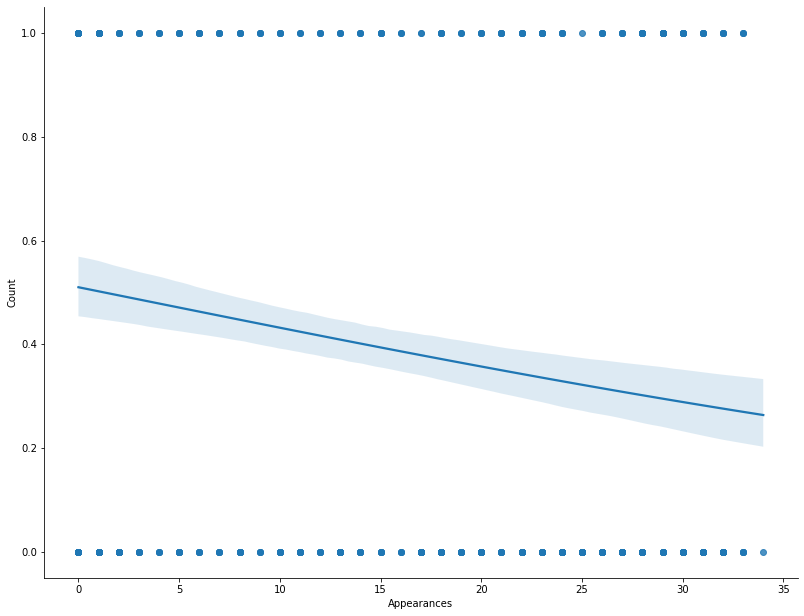

In [7]:
# Logistic regression based on appearances
plot_appear_list = []
for count, value in enumerate(appearances):
    plot_appear = []
    plot_appear.append(int(value))
    plot_appear.append(int(appear_label[count]))
    plot_appear_list.append(plot_appear)
    
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(appearances, appear_label, test_size=0.25, random_state=0)
X_train, X_test, y_train, y_test = np_arr(X_train, X_test, y_train, y_test)
model.fit(X_train, y_train)
print("Appearances Score: ", model.score(X_test, y_test))


appearances_df = pd.DataFrame(plot_appear_list, columns=["Appearances", "Count"])
ax = sns.regplot(x='Appearances', y='Count', data=appearances_df, logistic=True)
ax.figure.set_size_inches(13.5, 10.5)
sns.despine()



/Applications/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


Goals Score:  0.6180555555555556


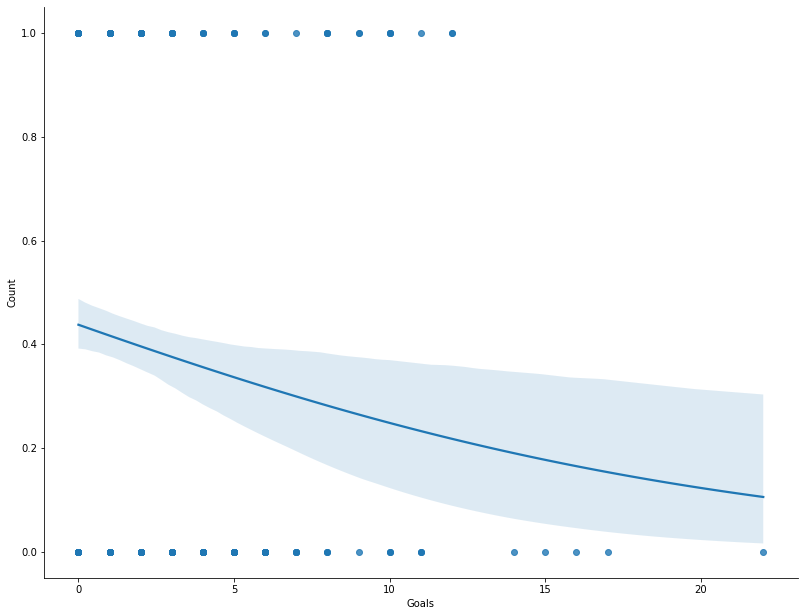

In [8]:
# Logistc regression based on goals
plot_goal_list = []
for count, value in enumerate(goals):
    plot_goal = []
    plot_goal.append(int(value))
    plot_goal.append(int(goal_label[count]))
    plot_goal_list.append(plot_goal)
    
X_train, X_test, y_train, y_test = train_test_split(goals, goal_label, test_size=0.25, random_state=0)
X_train, X_test, y_train, y_test = np_arr(X_train, X_test, y_train, y_test)
model.fit(X_train, y_train)
print("Goals Score: ", model.score(X_test, y_test))

goals_df = pd.DataFrame(plot_goal_list, columns=["Goals", "Count"])
ax = sns.regplot(x='Goals', y='Count',data=goals_df, logistic=True)
ax.figure.set_size_inches(13.5, 10.5)
sns.despine()


/Applications/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


Assists Score:  0.5842696629213483


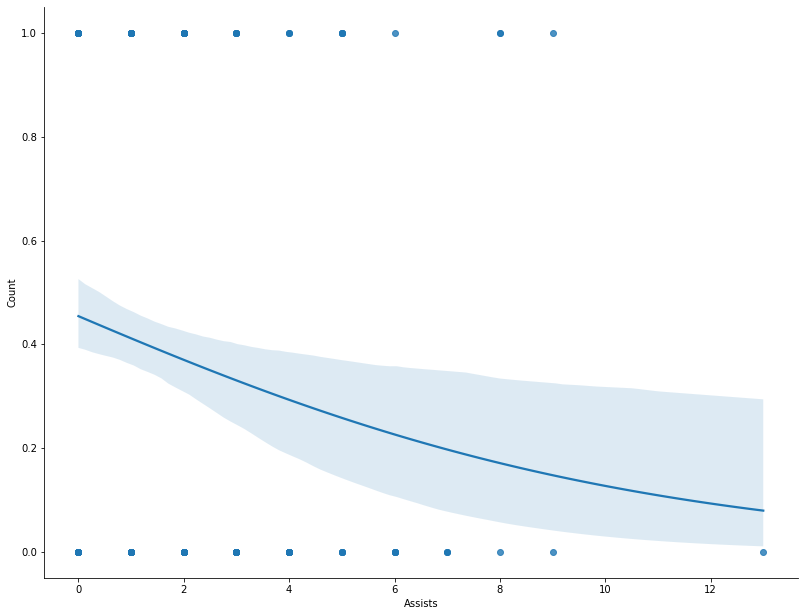

In [9]:
# Logistc regression based on assists
plot_assist_list = []
for count, value in enumerate(assists):
    plot_assist = []
    plot_assist.append(int(value))
    plot_assist.append(int(assist_label[count]))
    plot_assist_list.append(plot_assist)

X_train, X_test, y_train, y_test = train_test_split(assists, assist_label, test_size=0.25, random_state=0)
X_train, X_test, y_train, y_test = np_arr(X_train, X_test, y_train, y_test)
model.fit(X_train, y_train)
print("Assists Score: ", model.score(X_test, y_test))

assists_df = pd.DataFrame(plot_assist_list, columns=["Assists", "Count"])
ax = sns.regplot(x='Assists', y='Count', data=assists_df, logistic=True)
ax.figure.set_size_inches(13.5, 10.5)
sns.despine()


### PMI to evaluate the association between international players vs England players

In [10]:
# Total of players in the Premier League
sum=0
for i in team_dict:
    df=team_dict[i]
    for name in df['Name']:
        sum+=1
print(sum)   

654


In [11]:
# Find the number of co-occurance for each team

nationality_list=[]

def PMI1(get_nation):
    nationality_dict = {}
    df=team_dict[get_nation]
    for i in df['Nationality']:
       nationality_dict[i]=1
    return nationality_dict
    
for nation in team_dict:
    nationality_list.append(PMI1(nation))

nationality={}
for i in nationality_list:
    for key in i:
        if key not in nationality:
            nationality[key]=i[key]
        else:
            nationality[key]+=i[key]
    
print(nationality)        

            

{'Netherlands': 15, 'Northern Ireland': 7, 'England': 20, 'Scotland': 16, 'Germany': 9, 'Ireland': 12, 'Greece': 2, 'Turkey': 3, 'United States': 4, 'Poland': 6, 'Denmark': 6, 'Kosovo': 1, 'France': 18, 'Norway': 7, 'Finland': 3, 'Spain': 15, 'Belgium': 11, 'Wales': 11, 'Brazil': 13, 'Cameroon': 2, 'Guinea': 2, 'Senegal': 5, 'Egypt': 2, 'Portugal': 8, 'Japan': 2, 'Colombia': 6, 'Argentina': 8, 'Sweden': 6, 'Zimbabwe': 1, 'Burkina Faso': 1, 'Jamaica': 3, 'Ghana': 5, 'Switzerland': 3, 'Mexico': 2, 'Cote D’Ivoire': 6, 'Serbia': 2, 'Tunisia': 1, 'Uruguay': 2, 'Iraq': 1, 'Nigeria': 4, 'Thailand': 1, 'Zambia': 2, 'Bosnia & Herzegovina': 1, 'Ukraine': 3, 'Mali': 3, 'Venezuela': 1, 'Algeria': 2, 'Romania': 1, 'Ecuador': 1, 'Slovakia': 2, 'Paraguay': 1, 'New Zealand': 1, 'Italy': 3, 'Estonia': 1, 'South Korea': 2, 'Iceland': 2, 'Czech Republic': 2, 'Austria': 1, 'Morocco': 3, 'Chile': 1, '': 1, 'DR Congo': 3, 'Croatia': 2, 'Montenegro': 1, 'Grenada': 1, 'Iran': 1, 'Albania': 1}


In [12]:
# Find the total of players in each country
nationality2={}
for nation in team_dict:
    df= team_dict[nation]
    for i in df['Nationality']:
        if i not in nationality2:
            nationality2[i]=1
        else:
            nationality2[i]+=1
print(nationality2)

{'Netherlands': 20, 'Northern Ireland': 7, 'England': 267, 'Scotland': 27, 'Germany': 13, 'Ireland': 21, 'Greece': 3, 'Turkey': 3, 'United States': 5, 'Poland': 6, 'Denmark': 13, 'Kosovo': 1, 'France': 30, 'Norway': 8, 'Finland': 3, 'Spain': 27, 'Belgium': 14, 'Wales': 15, 'Brazil': 27, 'Cameroon': 2, 'Guinea': 2, 'Senegal': 5, 'Egypt': 2, 'Portugal': 23, 'Japan': 2, 'Colombia': 6, 'Argentina': 9, 'Sweden': 7, 'Zimbabwe': 1, 'Burkina Faso': 1, 'Jamaica': 3, 'Ghana': 6, 'Switzerland': 3, 'Mexico': 2, 'Cote D’Ivoire': 6, 'Serbia': 2, 'Tunisia': 1, 'Uruguay': 3, 'Iraq': 1, 'Nigeria': 9, 'Thailand': 1, 'Zambia': 2, 'Bosnia & Herzegovina': 1, 'Ukraine': 3, 'Mali': 3, 'Venezuela': 1, 'Algeria': 2, 'Romania': 1, 'Ecuador': 2, 'Slovakia': 2, 'Paraguay': 1, 'New Zealand': 1, 'Italy': 3, 'Estonia': 1, 'South Korea': 2, 'Iceland': 2, 'Czech Republic': 4, 'Austria': 1, 'Morocco': 4, 'Chile': 1, '': 1, 'DR Congo': 3, 'Croatia': 2, 'Montenegro': 1, 'Grenada': 1, 'Iran': 1, 'Albania': 1}


In [13]:
# Get the list of nations
get_nation=[]
for i in team_dict:
    df=team_dict[i]
    for nation in df['Nationality']:
        if nation not in get_nation and nation != '' and nation != 'England':
            get_nation.append(nation)
print(get_nation)


['Netherlands', 'Northern Ireland', 'Scotland', 'Germany', 'Ireland', 'Greece', 'Turkey', 'United States', 'Poland', 'Denmark', 'Kosovo', 'France', 'Norway', 'Finland', 'Spain', 'Belgium', 'Wales', 'Brazil', 'Cameroon', 'Guinea', 'Senegal', 'Egypt', 'Portugal', 'Japan', 'Colombia', 'Argentina', 'Sweden', 'Zimbabwe', 'Burkina Faso', 'Jamaica', 'Ghana', 'Switzerland', 'Mexico', 'Cote D’Ivoire', 'Serbia', 'Tunisia', 'Uruguay', 'Iraq', 'Nigeria', 'Thailand', 'Zambia', 'Bosnia & Herzegovina', 'Ukraine', 'Mali', 'Venezuela', 'Algeria', 'Romania', 'Ecuador', 'Slovakia', 'Paraguay', 'New Zealand', 'Italy', 'Estonia', 'South Korea', 'Iceland', 'Czech Republic', 'Austria', 'Morocco', 'Chile', 'DR Congo', 'Croatia', 'Montenegro', 'Grenada', 'Iran', 'Albania']


In [14]:
# Find pmi(x,y)
# x: Countries other than England
# y: England
country=[]
for nation in get_nation:
    score = []
    pmi=np.log2((nationality[nation]/sum)/((nationality2[nation]/sum)*(nationality2['England']/sum)))
    score.append(nation)
    score.append(pmi)
    country.append(score)
pmi_df = pd.DataFrame(country, columns=["Country","PMI"])
pmi_df = pmi_df.sort_values(by='PMI', ascending=False,ignore_index=True)
pmi_df


,Country,PMI
0,Mexico,1.292451
1,Slovakia,1.292451
2,Cote D’Ivoire,1.292451
3,Serbia,1.292451
4,Tunisia,1.292451
...,...,...
60,Ecuador,0.292451
61,Brazil,0.238003
62,Denmark,0.176974
63,Nigeria,0.122526
